In [28]:
#pip install statsmodels lightgbm seaborn scikit-learn joblib keras plotly
#pip install tensorflow
#pip install keras 

In [29]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import joblib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import plotly.graph_objs as go


In [30]:
def getYahooFinance(against_curr):
    # Define currency symbol lookup function inside getYahooFinance()
    def currSymbol(currency_name):
        currency_dict = {'Euro': 'USDEUR=X', 
                     'Pound': 'USDGBP=X', 
                     'Yen': 'USDJPY=X', 
                     'Canadian Dollar': 'USDCAD=X', 
                     'Swiss Franc': 'USDCHF=X', 
                     'Australian Dollar': 'USDAUD=X'}

        if currency_name in currency_dict:
            return currency_dict[currency_name]

    symbol = currSymbol(against_curr)
    tickers = symbol.split()

    # Convert start date to datetime object
    end_date = datetime.now().replace(hour=0,minute=0,second=0,microsecond=0)
    #end_date=datetime(2023,6,21)
    start_date = calcDatetime().replace(hour=0,minute=0,second=0, microsecond=0)
    #start_date = datetime(2002,6,21)

    interval = '1d'
    exchange_rates = []
    for ticker in tickers:
        t = yf.Ticker(ticker)
        exchange_rates.append(t.history(start=start_date, end=end_date, interval=interval))

    # Create a DataFrame of exchange rates
    ex_df = pd.concat(exchange_rates, axis=1)
    df = ex_df.drop(['Volume', 'Dividends', 'Stock Splits','Open','High','Low'], axis=1)
    return df

def calcDatetime():
    now = datetime.now()
    five_days_ago = now - timedelta(days=7)
    return datetime(five_days_ago.year, five_days_ago.month, five_days_ago.day)


In [31]:
# Define the function getYahooFinance
def getYahooFinance(against_curr):
    # Define currency symbol lookup function inside getYahooFinance()
    def currSymbol(currency_name):
        currency_dict = {'Euro': 'USDEUR=X', 
                     'Pound': 'USDGBP=X', 
                     'Yen': 'USDJPY=X', 
                     'Canadian Dollar': 'USDCAD=X', 
                     'Swiss Franc': 'USDCHF=X', 
                     'Australian Dollar': 'USDAUD=X'}

        if currency_name in currency_dict:
            return currency_dict[currency_name]

    symbol = currSymbol(against_curr)
    tickers = symbol.split()

    # Convert start date to datetime object
    end_date = datetime.now().replace(hour=0,minute=0,second=0,microsecond=0)
    #end_date=datetime(2023,6,21)
    start_date = calcDatetime().replace(hour=0,minute=0,second=0, microsecond=0)
    #start_date = datetime(2002,6,21)

    interval = '1d'
    exchange_rates = []
    for ticker in tickers:
        t = yf.Ticker(ticker)
        exchange_rates.append(t.history(start=start_date, end=end_date, interval=interval))

    # Create a DataFrame of exchange rates
    ex_df = pd.concat(exchange_rates, axis=1)
    df = ex_df.drop(['Volume', 'Dividends', 'Stock Splits','Open','High','Low'], axis=1)
    return df

# Call the getYahooFinance function to fetch data for Euro and display the DataFrame
df = getYahooFinance('Euro')
print(df)


                             Close
Date                              
2024-02-02 00:00:00+00:00  0.91957
2024-02-05 00:00:00+00:00  0.92764
2024-02-06 00:00:00+00:00  0.93094
2024-02-07 00:00:00+00:00  0.92961
2024-02-08 00:00:00+00:00  0.92801


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,5.0,0.927154,0.00444,0.91957,0.92764,0.92801,0.92961,0.93094


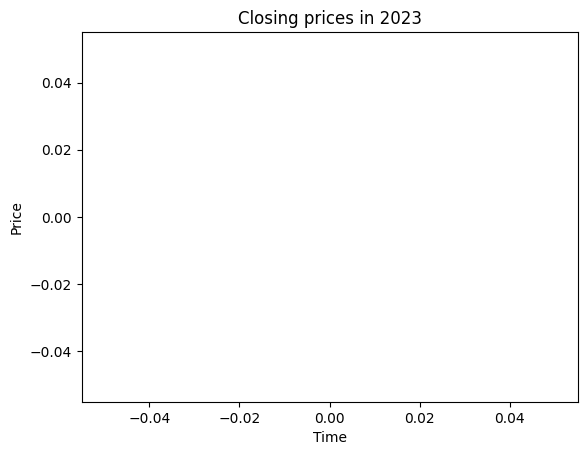

In [33]:
import matplotlib.pyplot as plt

# Filter the DataFrame to only include rows from 2023
df_2023 = df[df.index.year == 2023]

# Plot the 'close' column of the filtered DataFrame
plt.plot(df_2023['Close'])

# Add axis labels and a title
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Closing prices in 2023')

# Display the plot
plt.show()

In [34]:
def decompose_price_movement(df, curr='Close', samples=None, period=24):
    if samples is None:
        res = sm.tsa.seasonal_decompose(df[curr].values, period=period)
    else:
        res = sm.tsa.seasonal_decompose(df[curr].values[-samples:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    fig , axs = plt.subplots(4, figsize=(16, 8))
    axs[0].set_title('Observed', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()

    axs[1].set_title('Trend', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    axs[2].set_title('Seasonality', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    axs[3].set_title('Noise', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

In [35]:
decompose_price_movement(df)

ValueError: x must have 2 complete cycles requires 48 observations. x only has 5 observation(s)

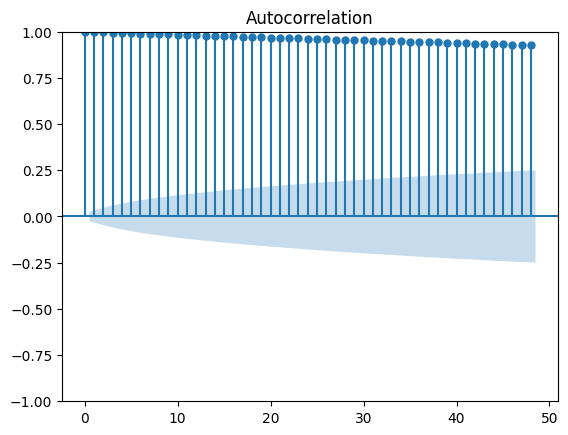

In [ ]:
plot_acf(df['Close'].values,lags=48)
plt.show()

In [ ]:
def train_time_series_with_folds(df,horizon=24*5):
    X =df.drop('Close',axis =1)
    y=df['Close']

    X_train ,X_test =X.iloc[:-horizon],X.iloc[-horizon:,:]
    print(len(X_train))
    y_train,y_test=y.iloc[:-horizon],y.iloc[-horizon:]

    model =lgb.LGBMRegressor(random_state=42, reg_alpha=0.1, reg_lambda=0.1)
    model.fit(X_train,y_train)
    predictions =model.predict(X_test)

    mae =np.round(mean_absolute_error(y_test,predictions),4)
    print(mae)
    #print(predictions)
    fig =plt.figure(figsize=(16,8))
    plt.title(f'Real vs Predictions -MAE {mae}',fontsize=20)
    plt.plot(y_test,color='red')
    plt.plot(pd.Series(predictions,index=y_test.index),color='green')
    plt.xlabel('Hour',fontsize =16)
    plt.ylabel('Closing pice ',fontsize = 16)
    plt.legend(labels=['Actual','Prediction'],fontsize=16)
    plt.grid()
    plt.show()


    df_importances =pd.DataFrame({
        'feature':model.feature_name_,
        'importance':model.feature_importances_
    }).sort_values(by='importance',ascending=False)

    plt.title('Variable Importance',fontsize=16)
    sns.barplot(y='feature', x='importance', data=df_importances, orient='h')
    plt.show()
    joblib.dump(model, 'time_series_model.pkl')

5329
0.4971


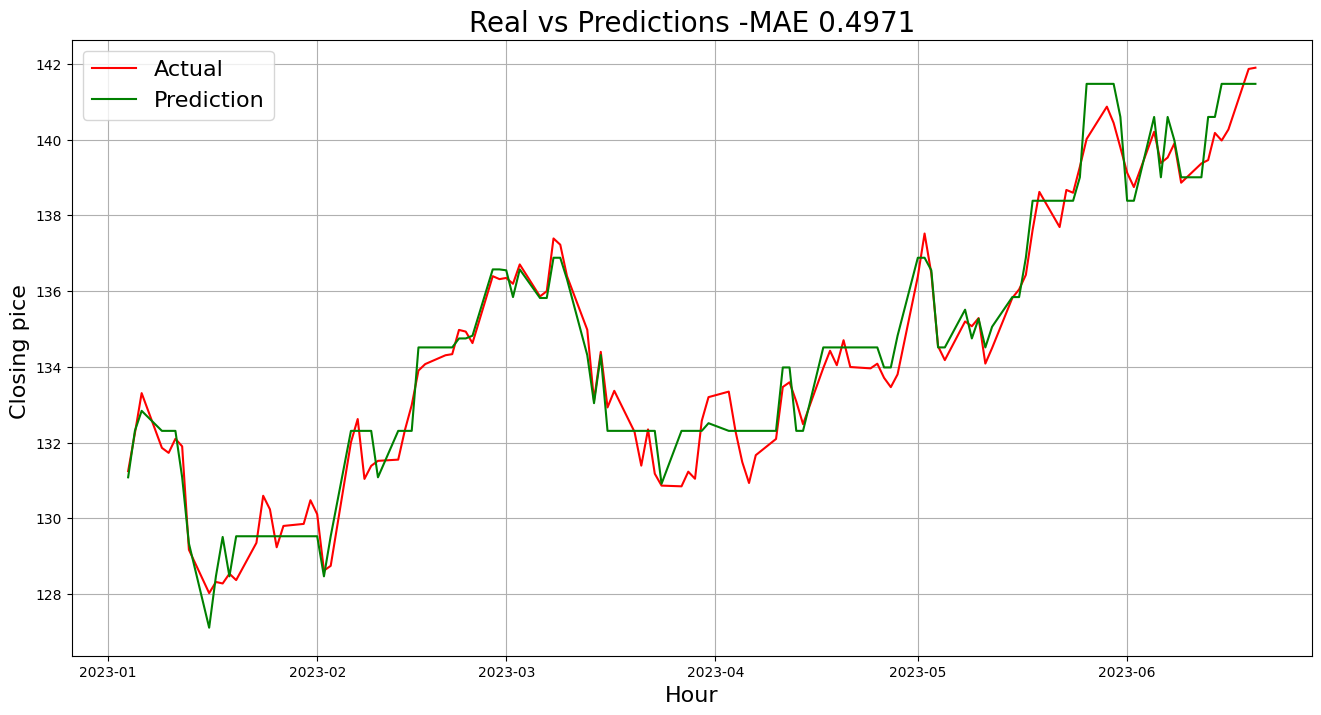

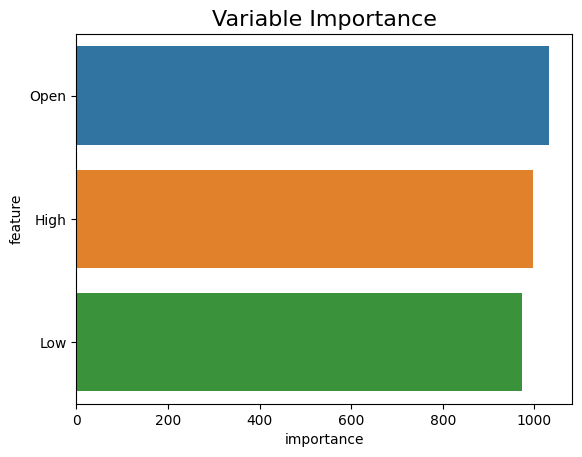

In [ ]:
train_time_series_with_folds(df)

In [ ]:
#train_time_series_with_folds(df)

In [ ]:
# shift the close prices 3 days ahead
df['close_next_3days'] = df['Close'].shift(24*7)

# drop the rows with NaN values (the last 3 days of data)
df.dropna(how='any', axis=0, inplace=True)

In [ ]:
df['close_next_3days'].head()

Date
2006-02-28 00:00:00+00:00    105.650002
2006-03-01 00:00:00+00:00    105.410004
2006-03-02 00:00:00+00:00    105.419998
2006-03-03 00:00:00+00:00    104.050003
2006-03-06 00:00:00+00:00    104.300003
Name: close_next_3days, dtype: float64

0.4654


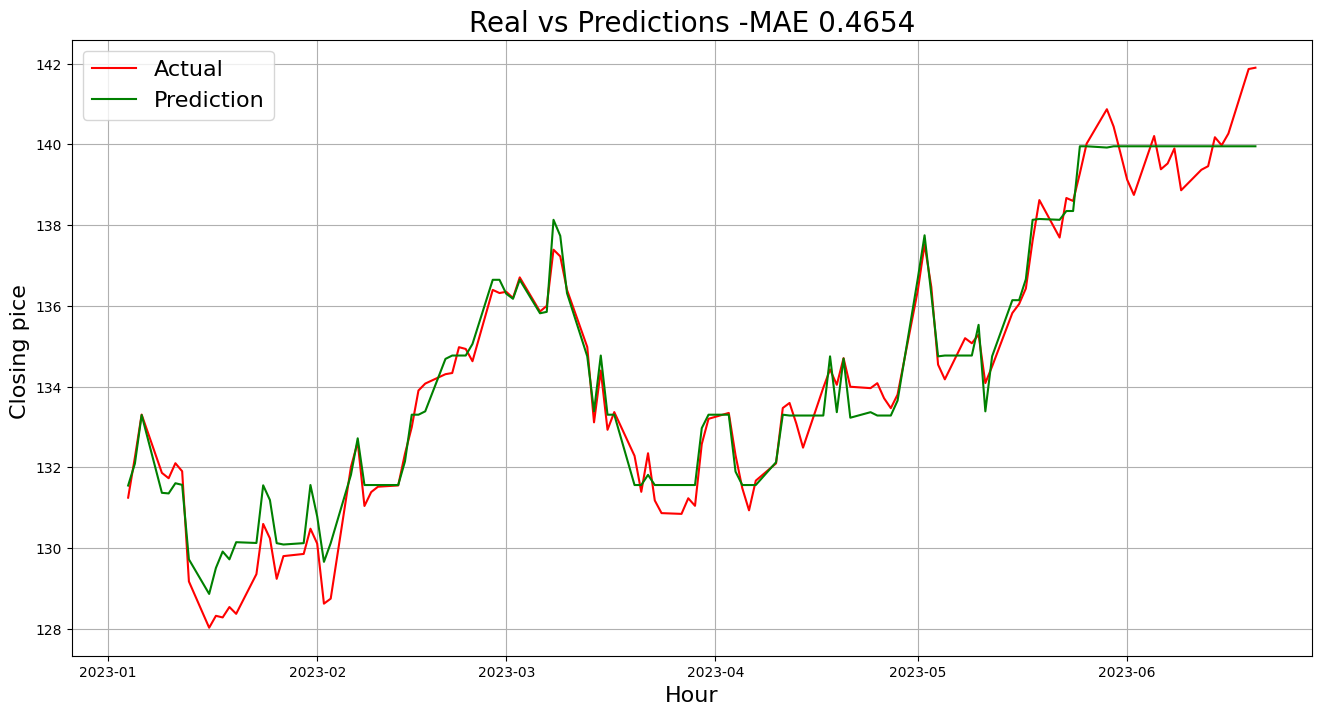

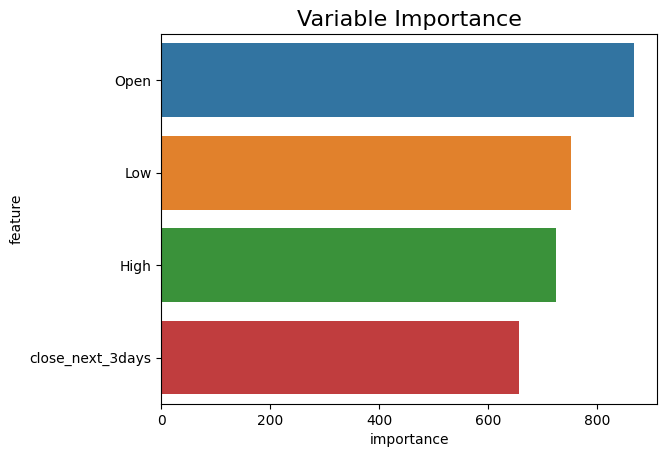

In [ ]:
train_time_series_with_folds(df)